In [3]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
df=pd.read_csv("/content/IBNSINA.csv",parse_dates=['DATE'])
df.head()

#       DATE TRADING CODE   LTP*  ...    YCP   TRADE  VALUE (mn)    VOLUME
0  439 2018-05-08      IBNSINA  306.0  ...  306.3  1217.0      64.278  206556.0
1  438 2018-06-08      IBNSINA  301.8  ...  306.1   744.0      32.516  107437.0
2  437 2018-07-08      IBNSINA  296.6  ...  300.3   817.0      37.425  125501.0
3  436 2018-08-08      IBNSINA  298.8  ...  295.1   708.0      39.266  131382.0
4  435 2018-09-08      IBNSINA  300.0  ...  296.3   628.0      24.447   82592.0

[5 rows x 12 columns]

In [4]:
# Sort DataFrame by date
df = df.sort_values('DATE')

# Double check the result
df.head()

#       DATE TRADING CODE   LTP*  ...    YCP  TRADE  VALUE (mn)    VOLUME
36  403 2018-01-10      IBNSINA  280.1  ...  279.7  698.0      31.318  110873.0
59  380 2018-01-11      IBNSINA  238.3  ...  240.4  296.0       6.548   27435.0
37  402 2018-02-10      IBNSINA  277.5  ...  280.3  827.0      33.399  120034.0
79  360 2018-02-12      IBNSINA  240.0  ...  242.0  477.0      10.392   43333.0
16  423 2018-03-09      IBNSINA  290.2  ...  292.6  391.0      20.225   69398.0

[5 rows x 12 columns]

In [5]:
df = df.set_index('DATE')
df.head(3)

# TRADING CODE   LTP*   HIGH  ...    YCP  TRADE  VALUE (mn)    VOLUME
DATE                                        ...                                    
2018-01-10  403      IBNSINA  280.1  285.0  ...  279.7  698.0      31.318  110873.0
2018-01-11  380      IBNSINA  238.3  241.4  ...  240.4  296.0       6.548   27435.0
2018-02-10  402      IBNSINA  277.5  282.8  ...  280.3  827.0      33.399  120034.0

[3 rows x 11 columns]

In [6]:
df['daily_ret'] = df['CLOSEP*'].pct_change()
df['daily_ret'] = df['daily_ret'].fillna(0.0)

In [7]:
df['volatility']= df['daily_ret'].rolling(window=21).std()
df['volatility'] = df['volatility'].fillna(0.0)

In [8]:
df['volatility'] = df['volatility']*100

In [9]:
import matplotlib.pyplot as plt 

In [10]:
df=df.reset_index()['volatility']

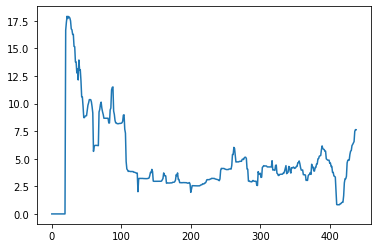

In [11]:
plt.plot(df)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [13]:
df.shape

(439, 1)

In [14]:
##splitting dataset into train and test split where train=70 percent and test=30 percent
training_size=int(len(df)*0.70)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]




In [15]:

training_size,test_size

(307, 132)

In [16]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [],[]
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [17]:

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [18]:

print(X_train.shape), print(y_train.shape)

(206, 100)
(206,)


(None, None)

In [19]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
from keras.optimizers import Adam

In [22]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:

model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
7/7 [==============================] - 9s 545ms/step - loss: 0.0247 - val_loss: 0.0236
Epoch 2/100
7/7 [==============================] - 2s 215ms/step - loss: 0.0042 - val_loss: 0.0198
Epoch 3/100
7/7 [==============================] - 1s 216ms/step - loss: 0.0031 - val_loss: 0.0179
Epoch 4/100
7/7 [==============================] - 2s 217ms/step - loss: 0.0028 - val_loss: 0.0172
Epoch 5/100
7/7 [==============================] - 1s 216ms/step - loss: 0.0025 - val_loss: 0.0171
Epoch 6/100
7/7 [==============================] - 1s 193ms/step - loss: 0.0019 - val_loss: 0.0170
Epoch 7/100
7/7 [==============================] - 1s 145ms/step - loss: 0.0018 - val_loss: 0.0170
Epoch 8/100
7/7 [==============================] - 1s 150ms/step - loss: 0.0018 - val_loss: 0.0170
Epoch 9/100
7/7 [==============================] - 1s 144ms/step - loss: 0.0020 - val_loss: 0.0171
Epoch 10/100
7/7 [==============================] - 1s 142ms/step - loss: 0.0018 - val_loss: 0.0168
Epoch 11/

In [25]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [26]:

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [27]:

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
X = np.reshape(ytest,(1, ytest.size))
Y_test =scaler.inverse_transform(X)

In [28]:
Y_test = Y_test.transpose()
RMSE = math.sqrt(mean_squared_error(Y_test,test_predict))
RMSE

1.6944649786497314

In [29]:
Y_test

array([[3.40031531],
       [3.33576764],
       [2.16976503],
       [0.84743907],
       [0.83024663],
       [0.83047049],
       [0.83251486],
       [0.83251486],
       [0.92133951],
       [0.92475339],
       [1.01814602],
       [1.0480618 ],
       [1.05894413],
       [1.64421273],
       [2.81218613],
       [3.18640458],
       [3.18495377],
       [3.40556798],
       [4.62212599],
       [4.8637966 ],
       [4.87696143],
       [4.87595992],
       [5.39006825],
       [5.68439031],
       [5.74525138],
       [6.19616053],
       [6.29838604],
       [6.42966536],
       [6.55622475],
       [7.47836252],
       [7.63840352]])

In [30]:
test_predict

array([[4.2239127],
       [4.0453453],
       [3.8760645],
       [3.670251 ],
       [3.389905 ],
       [3.0752263],
       [2.7662835],
       [2.4890215],
       [2.2551494],
       [2.0695338],
       [1.9277589],
       [1.8253666],
       [1.7549663],
       [1.7086086],
       [1.6987596],
       [1.7572936],
       [1.8820909],
       [2.047472 ],
       [2.236002 ],
       [2.4765325],
       [2.7616563],
       [3.0665097],
       [3.3675592],
       [3.6735723],
       [3.9882774],
       [4.301818 ],
       [4.62571  ],
       [4.9525046],
       [5.2750936],
       [5.5878196],
       [5.937791 ]], dtype=float32)

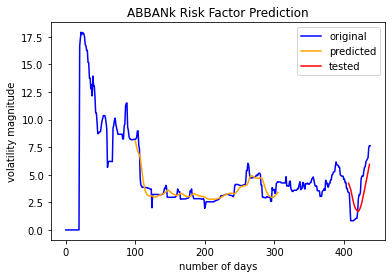

In [31]:

### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df),color ='blue', label ='original')
plt.plot(trainPredictPlot, color ='orange', label ='predicted')
plt.plot(testPredictPlot , color ='red', label ='tested')
#plt.show()
plt.xlabel('number of days')
plt.ylabel('volatility magnitude')
plt.title('ABBANk Risk Factor Prediction')
plt.legend(loc='best')
plt.show(block=False)


In [32]:

x_input=test_data[32:].reshape(1,-1)
x_input.shape

(1, 100)

In [33]:

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)


[0.3738575]
101
1 day input [0.21034923 0.24016683 0.23773488 0.21679126 0.20655854 0.23386263
 0.23273164 0.23533765 0.23681254 0.23043072 0.23100133 0.23408524
 0.2404722  0.24048971 0.25854312 0.25947327 0.26788662 0.25391178
 0.23435053 0.22137869 0.22165393 0.22232592 0.19842584 0.19816109
 0.19816717 0.19669179 0.16916332 0.17279499 0.1693043  0.19310993
 0.19841706 0.20067505 0.20924697 0.19997611 0.25131766 0.23492201
 0.23777644 0.21766369 0.21651669 0.23508062 0.235075   0.2521898
 0.25274649 0.27864326 0.2800198  0.29223096 0.29394918 0.29529714
 0.32445863 0.34408784 0.33033954 0.32750826 0.32574343 0.3174335
 0.31746569 0.27868173 0.2752521  0.27212711 0.27212711 0.27180815
 0.25617396 0.25696139 0.23930292 0.24051385 0.20989876 0.21020032
 0.19193799 0.18984821 0.18624435 0.12114348 0.04731467 0.04635477
 0.04636727 0.04648141 0.04648141 0.05144072 0.05163132 0.05684567
 0.05851594 0.05912353 0.09180056 0.15701147 0.17790503 0.17782403
 0.19014148 0.258065   0.27155808 0.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)

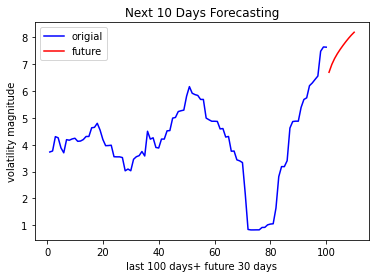

In [38]:

plt.plot(day_new,scaler.inverse_transform(df[339:]),color ='blue', label ='origial')
plt.plot(day_pred,scaler.inverse_transform(lst_output),color='red', label='future')
plt.xlabel('last 100 days+ future 30 days')
plt.ylabel('volatility magnitude')
plt.title('Next 10 Days Forecasting')
plt.legend(loc='best')
plt.show(block=False)

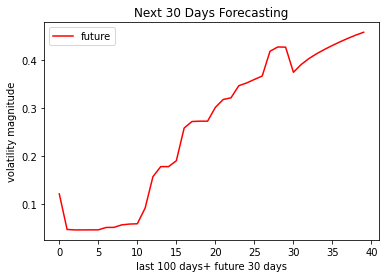

In [39]:
df3=df.tolist()
df3.extend(lst_output)
plt.xlabel('last 100 days+ future 30 days')
plt.ylabel('volatility magnitude')
plt.title('Next 30 Days Forecasting')
plt.plot(df3[409:],color='red', label='future')
plt.legend(loc='best')
plt.show(block=False)

In [40]:
df3=scaler.inverse_transform(df3).tolist()

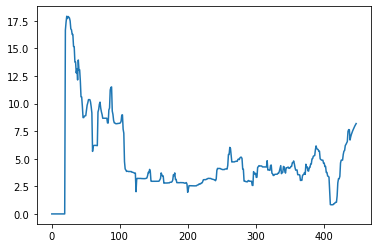

In [41]:
plt.plot(df3)